In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.utils import plot_model
from tensorflow.keras.activations import sigmoid
from tensorflow.keras.optimizers import SGD,Adam
from keras_radam.training import RAdamOptimizer
from tensorflow.keras.callbacks import LearningRateScheduler,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler

tf.compat.v1.disable_eager_execution()

from VAE_small import *

model_num = 14

learning_rate_1 = 0.0001
learning_rate_2 = 0.005
momentum = 0.9
batch_size = 4
epoch_num = 1000

In [2]:
#TF2.0
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(physical_devices[1], 'GPU')
tf.config.experimental.set_memory_growth(physical_devices[1], True)
# ------------------------------------------------------------------------------

In [3]:
model = get_model()

inputs = model['inputs']
outputs = model['outputs']
mu = model['mu']
sigma = model['sigma']
z = model['z']

encoder = model['encoder']
decoder = model['decoder']

#plot_model(encoder, to_file = 'vae_encoder_{}.png'.format(model_num), show_shapes = True)
#plot_model(decoder, to_file = 'vae_decoder_{}.png'.format(model_num), show_shapes = True)

vae = model['vae']

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [4]:
def weighted_binary_crossentropy(target, output):
    loss = -(98.0 * target * K.log(output) + 2.0 * (1.0 - target) * K.log(1.0 - output)) / 100.0
    return loss

def mse(target, output):
    loss = K.square((output-target))
    return loss

def kl_div(mu,sigma):
    return -0.5 * K.mean(1 + 2 * sigma - K.square(mu) - K.exp(2 * sigma))

def voxel_loss(inputs,outputs):# = 
    return K.cast(K.mean(weighted_binary_crossentropy(inputs, K.clip(K.sigmoid(outputs), 1e-7, 1.0 - 1e-7))), 'float32')+ kl_div(model['mu'],model['sigma'])
#    return 0.01*K.cast(K.mean(mse(inputs, K.clip(K.sigmoid(outputs), 1e-7, 1.0 - 1e-7))), 'float32')+ kl_div(model['mu'],model['sigma'])
# K.clip(a,a_min,a_max) = make a in range a_min to a_max


def custom_acc(y_true, y_pred):
    return K.mean(K.equal(K.round(y_true*10), K.round(y_pred*10)))

sgd = SGD(lr = learning_rate_1, momentum = momentum, nesterov = True)
adam = Adam(lr=1e-3)
radam = RAdamOptimizer(learning_rate=1e-3)

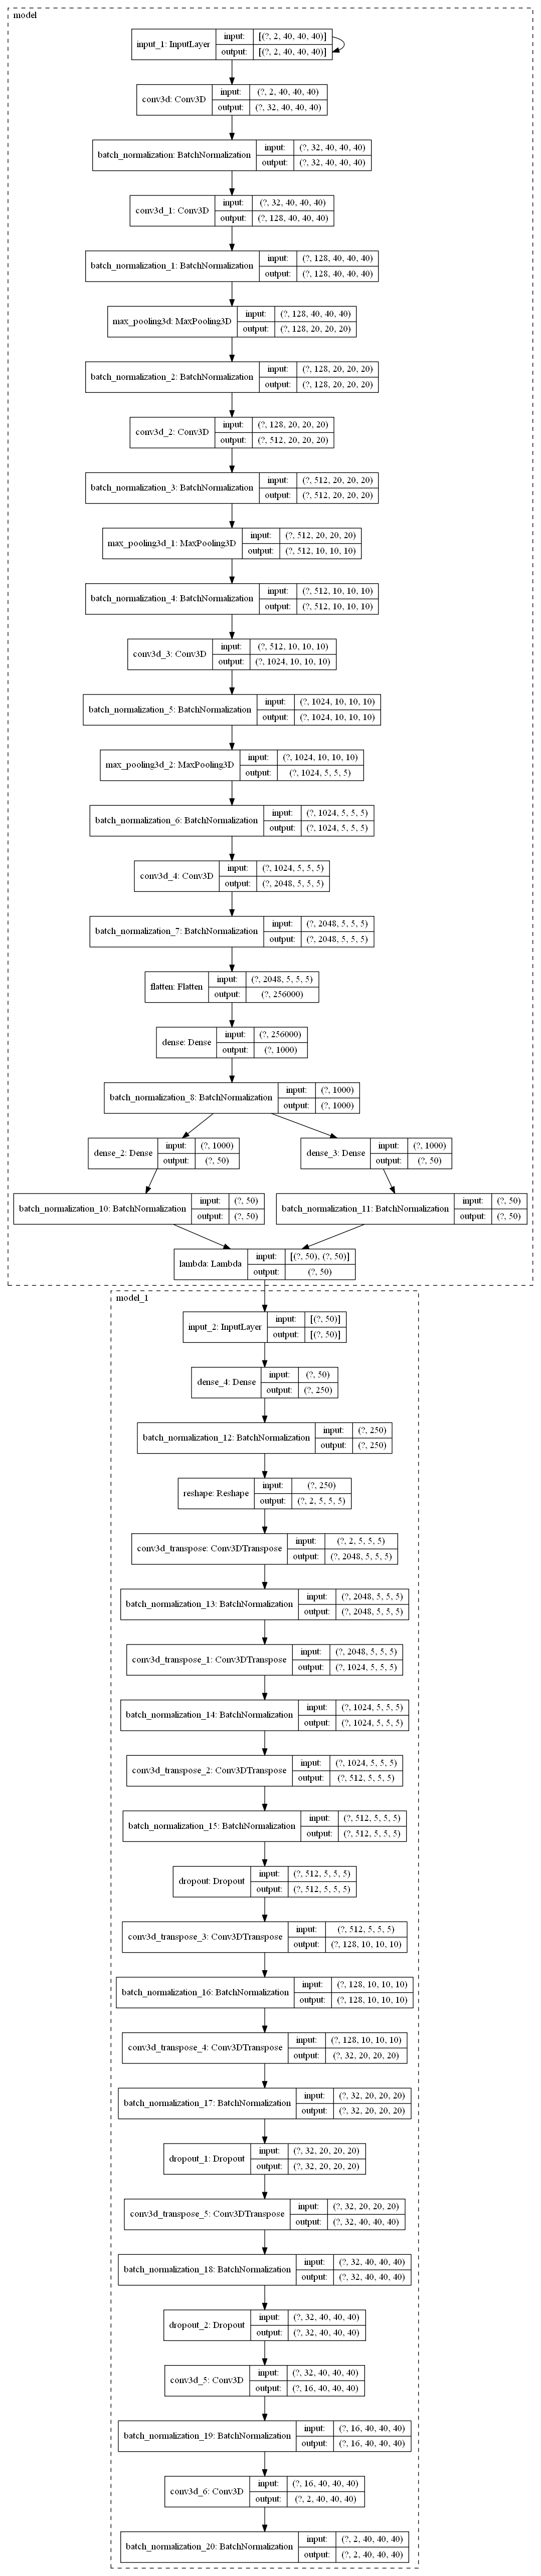

In [5]:
vae.compile(optimizer = adam, metrics = ['accuracy',custom_acc], loss=voxel_loss)

plot_model(vae, to_file = 'vae_{}.png'.format(model_num), show_shapes = True, expand_nested = True)

In [6]:
vae.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2, 40, 40, 40)]   0         
_________________________________________________________________
model (Model)                [(None, 50), (None, 50),  278884116 
_________________________________________________________________
model_1 (Model)              (None, 2, 40, 40, 40)     21601820  
Total params: 300,485,936
Trainable params: 300,482,606
Non-trainable params: 3,330
_________________________________________________________________


In [7]:
def make_dataset(mol_name):
    data = []
    for i in range(50):
        data_0 = np.load('volume_fraction/{}_0/{}[{}].npy'.format(mol_name,mol_name,i+51))
        data.append(data_0)
    return data

In [8]:
data_cross = make_dataset('Cross')
data_diblock = make_dataset('Diblock')
data_dragonfly = make_dataset('Dragonfly')
data_hydrophilic = make_dataset('HydrophilicSideChain1')
data_triblock = make_dataset('Triblock')
data_tshape = make_dataset('T-shape')
data_cross[0].shape

(4, 80, 80, 80)

In [9]:
data_train = np.vstack((data_cross,data_diblock,data_dragonfly,data_hydrophilic,data_triblock,data_tshape))
data_train = data_train.reshape(-1,4,80,80,80)
data_train[:,1,:,:,:] = data_train[:,2,:,:,:]
data_train = data_train[:,:2,:,:,:]
data_train.shape

(300, 2, 80, 80, 80)

In [10]:
A_max = np.max(data_train[:,0,:,:,:])
B_max = np.max(data_train[:,1,:,:,:])
#C_max = np.max(data_train[:,2,:,:,:])
#W_max = np.max(data_train[:,3,:,:,:])

data_train[:,0,:,:,:] /= A_max
data_train[:,1,:,:,:] /= B_max
#data_train[:,2,:,:,:] /= C_max
#data_train[:,3,:,:,:] /= W_max

In [11]:
data_train = data_train[:,:,20:60,20:60,20:60]
data_train.shape

(300, 2, 40, 40, 40)

In [12]:
early_stopping = EarlyStopping(monitor='loss',min_delta=1e-8,patience=5,verbose=0,mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, min_lr=1e-7)

history = vae.fit(
    data_train,
    data_train,
    epochs = epoch_num,
    batch_size = batch_size,
#    validation_data = (data_train, None),
    callbacks = [reduce_lr,early_stopping]
)

vae.save_weights('vae_{}.h5'.format(model_num))

Train on 300 samples
Epoch 1/1000
300/300 [==============================] - 31s 103ms/sample - loss: 2.5120 - accuracy: 0.0238 - custom_acc: 0.0301
Epoch 2/1000
300/300 [==============================] - 24s 80ms/sample - loss: 1.4729 - accuracy: 0.0254 - custom_acc: 0.0393
Epoch 3/1000
300/300 [==============================] - 24s 81ms/sample - loss: 1.1540 - accuracy: 0.0258 - custom_acc: 0.0238
Epoch 4/1000
300/300 [==============================] - 24s 81ms/sample - loss: 0.9000 - accuracy: 0.0270 - custom_acc: 0.0224
Epoch 5/1000
300/300 [==============================] - 24s 81ms/sample - loss: 0.7592 - accuracy: 0.0281 - custom_acc: 0.0213
Epoch 6/1000
300/300 [==============================] - 24s 81ms/sample - loss: 0.7783 - accuracy: 0.0286 - custom_acc: 0.0215
Epoch 7/1000
300/300 [==============================] - 24s 81ms/sample - loss: 0.6789 - accuracy: 0.0283 - custom_acc: 0.0196
Epoch 8/1000
300/300 [==============================] - 24s 82ms/sample - loss: 0.5564 - 

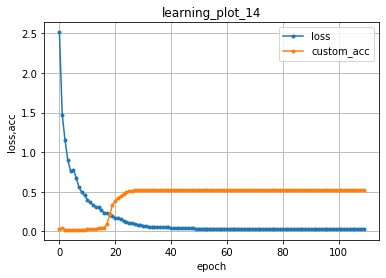

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
acc = history.history['custom_acc']

epochs = len(loss)
plt.plot(range(epochs), loss, marker='.', label='loss')
plt.plot(range(epochs), acc, marker='.', label='custom_acc')
plt.legend(loc='best')
plt.grid()
plt.title("learning_plot_{}".format(model_num))
plt.xlabel('epoch')
plt.ylabel('loss,acc')
plt.savefig("learning_plot_{}.png".format(model_num))
plt.show()

In [14]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

x_test_encoded = encoder.predict(data_train, batch_size=16)
x_test_encoded = np.array(x_test_encoded)
mu = x_test_encoded[0]
sigma = x_test_encoded[1]
z = x_test_encoded[2]

ones = np.ones([50,1])
y_test = np.vstack((ones,ones*2,ones*3,ones*4,ones*5,ones*6))

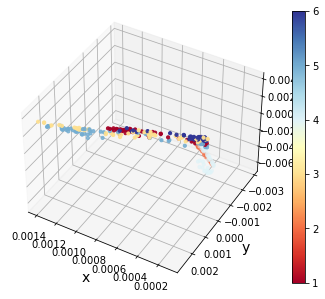

In [15]:
%matplotlib inline
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')
#scatter = plt.scatter(x_test_encoded[2,:,0], x_test_encoded[2,:,1], c=y_test, cmap='RdYlBu')
scatter = ax.scatter(np.std(sigma[:,:],axis=-1),
                     np.mean(mu[:,:25],axis=-1),
                     np.mean(mu[:,25:],axis=-1),
                     c=y_test, cmap='RdYlBu', s=10)
ax.set_xlabel("x", size = 14)
ax.set_ylabel("y", size = 14)
ax.set_zlabel("z", size = 14)
fig.colorbar(scatter)
ax.view_init(elev=40, azim=120)
plt.show()

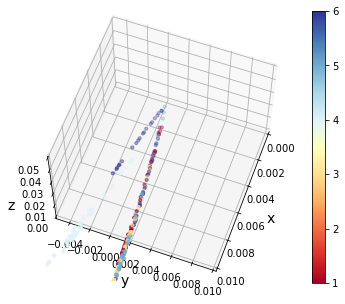

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')
#scatter = plt.scatter(x_test_encoded[2,:,0], x_test_encoded[2,:,1], c=y_test, cmap='RdYlBu')
scatter = ax.scatter(np.std(mu[:,:15],axis=-1),
                     np.mean(mu[:,15:30],axis=-1),
                     np.std(mu[:,30:],axis=-1),
                     c=y_test, cmap='RdYlBu', s=10)
ax.set_xlabel("x", size = 14)
ax.set_ylabel("y", size = 14)
ax.set_zlabel("z", size = 14)
fig.colorbar(scatter)
ax.set_xlim(0,0.01)
ax.set_ylim(-0.005,0.01)
ax.set_zlim(-0.001,0.05)
ax.view_init(elev=60, azim=20)
plt.show()

In [17]:
outputs = decoder.predict(z)

outputs[np.where(outputs<=-0.001)]=0
outputs[np.where(outputs<0)]*=-1

outputs[:,0,:,:,:] *= A_max
outputs[:,1,:,:,:] *= B_max
outputs[:,2,:,:,:] *= C_max
#outputs[:,3,:,:,:] *= W_max

np.save('volume_fraction/outputs_{}'.format(model_num), outputs)

IndexError: index 2 is out of bounds for axis 1 with size 2

In [ ]:
np.max(outputs)

In [ ]:
import pandas as pd
df = pd.DataFrame(outputs[0,1,20,:,:].reshape(-1,1))
df.describe()

In [ ]:
z_sample = np.random.normal(loc=0.1, scale=0.8, size=(1,10))

x_decoded = decoder.predict(z_sample)

np.save('volume_fraction/x_decoded_{}'.format(model_num), x_decoded)